# NỘI DUNG ĐỀ TÀI

### Sử dụng Hierarchical Clustering Dự báo xu hướng giá vàng, Phát hiện các mô hình trong quá khứ có thể lặp lại trong tương lai.
* Hỗ trợ đầu tư: Giúp nhà đầu tư phân loại giai đoạn thị trường và đưa ra chiến lược phù hợp.
* Phân tích tác động kinh tế: Xác định ảnh hưởng của các chỉ số tài chính đến giá vàng.

Trong dự án này, chúng tôi sử dụng hàm linkage thực hiện phân cụm phân cấp với phường thức là Euclidean Distance giúp xác định khoảng cách giữa các cụm.

### Chuẩn bị dữ liệu
* Dữ liệu giá vàng được tải từ Yahoo Finance (GLD), quy đổi sang VND/lượng.
* Tính hai đặc trưng: Daily_Change (% thay đổi giá hàng ngày) và Volatility (độ lệch chuẩn 7 ngày).


# Chuẩn bị thư viện và thiết lập dữ liệu

In [22]:
# Import các thư viện cần thiết
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from datetime import datetime
import requests


In [ ]:
# Dùng thư viện yfinance để lấy giá cổ phiếu GLD -SPDR Gold Shares (đại diện giá vàng thế giới)- Yahoo Finance

# Chỉ lấy giá đóng cửa (Close)

ticker = "GLD"
data = yf.download(ticker, start="2025-01-01", end=datetime.today().date())  
print(data)
data = data[['Close']].reset_index()  
data.columns = ['Date', 'Gold_Price']

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             GLD         GLD         GLD         GLD       GLD
Date                                                                
2025-01-02  245.419998  245.529999  244.080002  244.220001   6241900
2025-01-03  243.490005  244.820007  243.360001  244.559998   4872100
2025-01-06  243.190002  243.789993  242.050003  242.330002   3758900
2025-01-07  244.559998  245.770004  243.809998  245.520004   5090300
2025-01-08  245.860001  246.449997  244.509995  245.720001   6303300
...                ...         ...         ...         ...       ...
2025-05-02  297.980011  300.850006  297.029999  300.170013   8678400
2025-05-05  306.880005  307.649994  304.679993  305.920013   8924000
2025-05-06  315.480011  315.619995  311.399994  313.119995  11445300
2025-05-07  310.750000  313.260010  310.079987  312.100006   7910000
2025-05-08  304.630005  310.465088  303.049988  309.760010  11878447

[87 rows x 5 columns]


In [29]:
# Lấy tỷ giá chuẩn từ API
def get_exchange_rate():
    try:
        response = requests.get("https://api.exchangerate-api.com/v4/latest/USD")
        exchange_rate = response.json()['rates']['VND']
        return exchange_rate
    except:
        return 25000  
   
#Quy đổi thành:
# USD/ounce
# VND/lượng (quy đổi theo tỷ giá USD/VND)

data['Gold_Price_Ounce'] = data['Gold_Price'] * 10  
data['Gold_Price_VND_per_Luong'] = (data['Gold_Price_Ounce'] * get_exchange_rate()) / 0.8294  # VND/lượng


In [30]:
# Tính toán đặc trưng
# Tính % thay đổi giá mỗi ngày
# Tính độ lệch chuẩn 7 ngày làm biến động

data['Daily_Change'] = data['Gold_Price_VND_per_Luong'].pct_change() * 100  # % thay đổi
data['Volatility'] = data['Gold_Price_VND_per_Luong'].rolling(window=7).std()  # Biến động 7 ngày
data = data.dropna()  # Loại bỏ NaN

In [31]:
# Chuẩn hóa dữ liệu bằng StandardScaler để đưa về cùng thang đo

X = data[['Daily_Change', 'Volatility']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

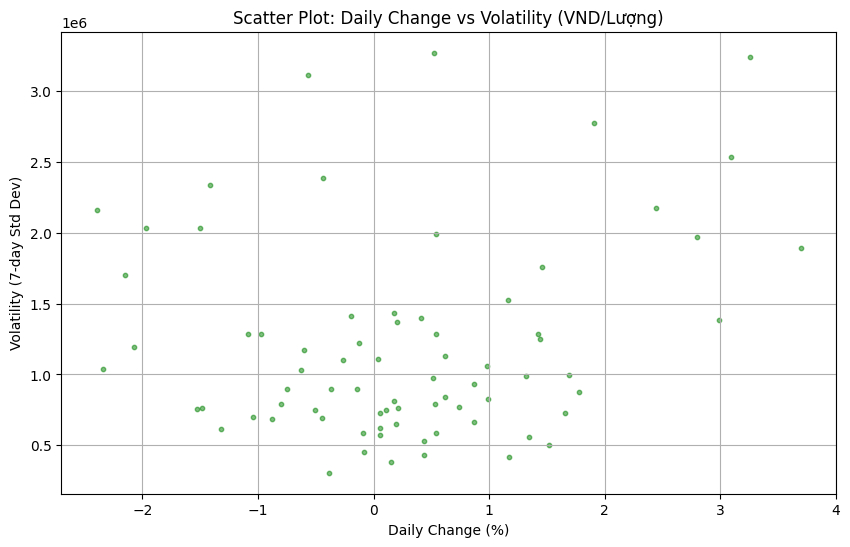

In [32]:
# 1. Vẽ scatter plot của Daily_Change và Volatility

plt.figure(figsize=(10, 6))
plt.scatter(data['Daily_Change'], data['Volatility'], s=10, c='green', alpha=0.5)
plt.title('Scatter Plot: Daily Change vs Volatility (VND/Lượng)')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.grid(True)
plt.show()

# Áp dụng Hierarchical Clustering bằng phương thức Euclidean Method

In [33]:
# Sử dụng phép gom cụm phân cấp (hierarchical clustering) với hàm linkage từ thư viện SciPy,tạo ra ma trận liên kết Z,giúp xác định cách nhóm điểm dữ liệu lại thành cụm. 

Z = linkage(X_scaled, method='average', metric='euclidean')

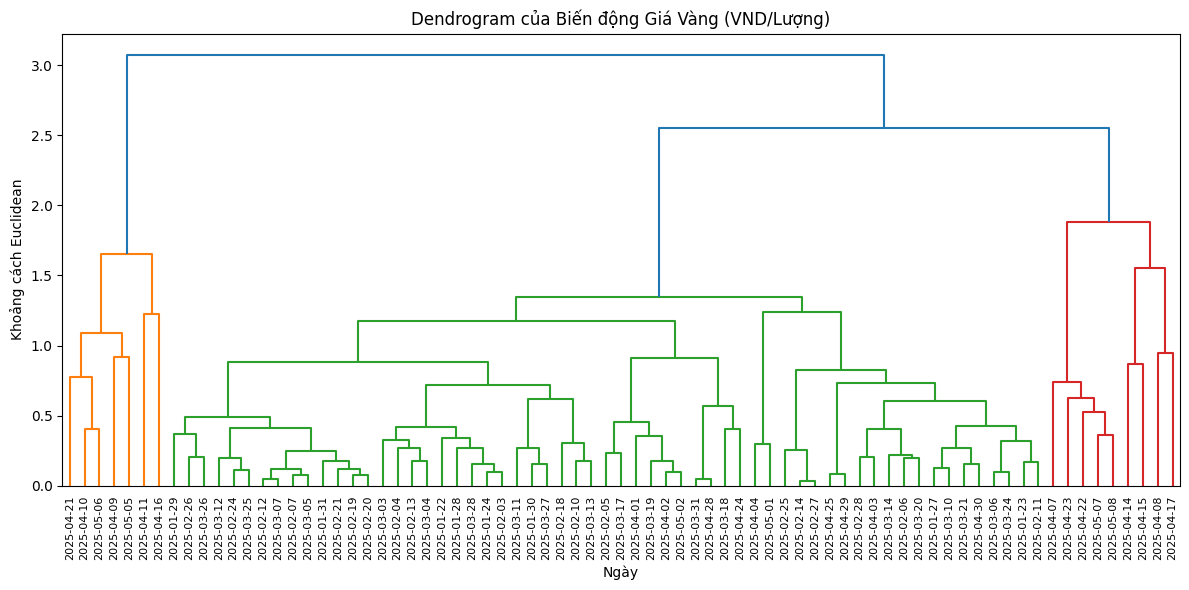

In [34]:
# Dùng dendrogram để trực quan hoá cách các điểm được gom thành từng cụm

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=data['Date'].dt.strftime('%Y-%m-%d').values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram của Biến động Giá Vàng (VND/Lượng)')
plt.xlabel('Ngày')
plt.ylabel('Khoảng cách Euclidean')
plt.tight_layout()
plt.show()


In [35]:
# Chọn số cụm = 3 và gán nhãn cụm cho từng ngày

num_hierarchical_clusters = 3  
hierarchical_clusters = fcluster(Z, t=num_hierarchical_clusters, criterion='maxclust')
data['Cluster'] = hierarchical_clusters



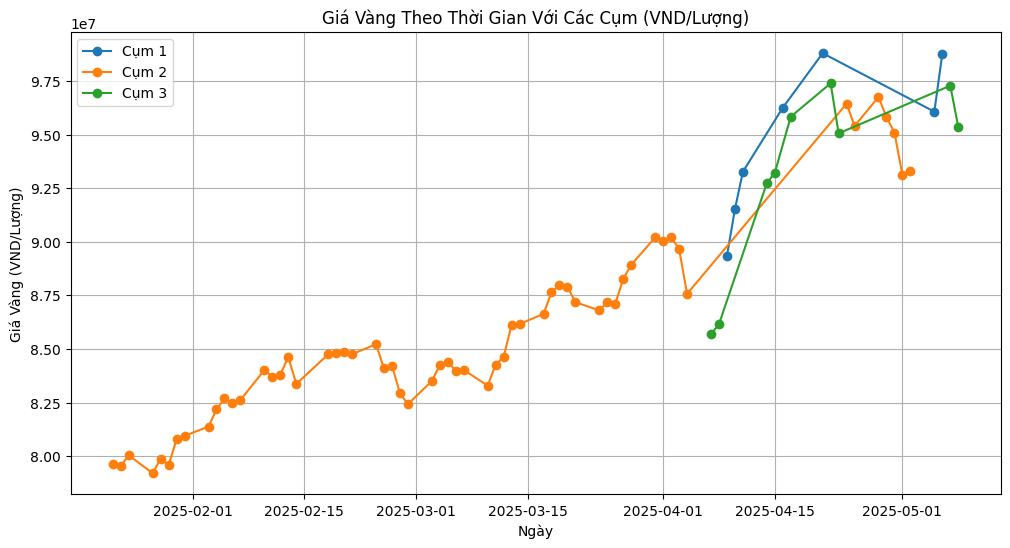

In [36]:
# Hiển thị biểu đồ:
# Biểu đồ giá vàng theo từng cụm màu

plt.figure(figsize=(12, 6))
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    plt.plot(cluster_data['Date'], cluster_data['Gold_Price_VND_per_Luong'], label=f'Cụm {cluster}', marker='o', linestyle='-')
plt.title('Giá Vàng Theo Thời Gian Với Các Cụm (VND/Lượng)')
plt.xlabel('Ngày')
plt.ylabel('Giá Vàng (VND/Lượng)')
plt.legend()
plt.grid(True)
plt.show()

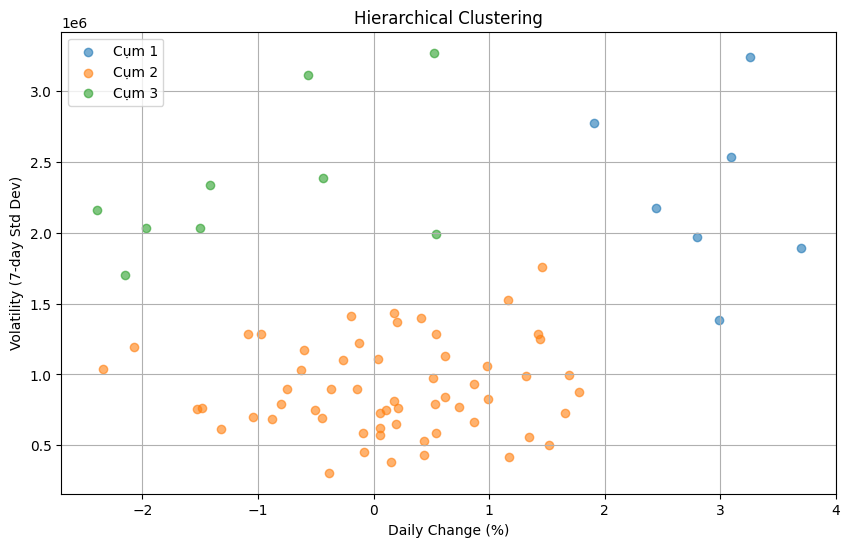

In [37]:
# Biểu đồ phân tán giữa Daily Change và Volatility theo từng cụm.

plt.figure(figsize=(10, 6))
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Daily_Change'], cluster_data['Volatility'], label=f'Cụm {cluster}', alpha=0.6)
plt.title('Hierarchical Clustering')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.legend()
plt.grid(True)

In [38]:
#  Phân tích cụm:
# Mỗi cụm đại diện cho các giai đoạn có đặc điểm biến động và thay đổi giá khác nhau

print("Thông tin các cụm:")
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"Cụm {cluster}: {len(cluster_data)} ngày, Biến động trung bình: {cluster_data['Volatility'].mean():.2f}, Thay đổi trung bình: {cluster_data['Daily_Change'].mean():.2f}%")

Thông tin các cụm:
Cụm 1: 7 ngày, Biến động trung bình: 2281537.71, Thay đổi trung bình: 2.88%
Cụm 2: 59 ngày, Biến động trung bình: 894948.97, Thay đổi trung bình: 0.14%
Cụm 3: 9 ngày, Biến động trung bình: 2337763.29, Thay đổi trung bình: -1.04%


# Áp dụng K-Means Clustering

In [39]:
# Dùng KMeans(n_clusters=3) để phân cụm cùng dữ liệu.

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_scaled)
data['KMeans_Cluster'] = kmeans_clusters + 1  # +1 để nhãn cụm bắt đầu từ 1

# Đánh giá hiệu suất giữa Hierarchical Cluster và K-Means Clustering

In [41]:
# So sánh hiệu quả giữa 2 thuật toán bằng:

# Silhouette Score (cao hơn → tốt hơn)

# Davies-Bouldin Index (thấp hơn → tốt hơn)

# Silhouette Score (càng cao càng tốt, từ -1 đến 1)
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_clusters)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_clusters)

# Davies-Bouldin Index (càng thấp càng tốt)
hierarchical_db = davies_bouldin_score(X_scaled, hierarchical_clusters)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_clusters)

print("So sánh hiệu suất:")
print("- Silhouette Score càng cao càng tốt, từ -1 đến 1")
print(f"\t + Silhouette Score (Hierarchical): {hierarchical_silhouette:.4f}")
print(f"\t + Silhouette Score (K-Means): {kmeans_silhouette:.4f}")
print("- Davies-Bouldin càng thấp càng tốt")
print(f"\t + Davies-Bouldin Index (Hierarchical): {hierarchical_db:.4f}")
print(f"\t + Davies-Bouldin Index (K-Means): {kmeans_db:.4f}")

So sánh hiệu suất:
- Silhouette Score càng cao càng tốt, từ -1 đến 1
	 + Silhouette Score (Hierarchical): 0.5182
	 + Silhouette Score (K-Means): 0.4847
- Davies-Bouldin càng thấp càng tốt
	 + Davies-Bouldin Index (Hierarchical): 0.7077
	 + Davies-Bouldin Index (K-Means): 0.7517


# 5. Vẽ biểu đồ giá vàng với các cụm (K-Means)

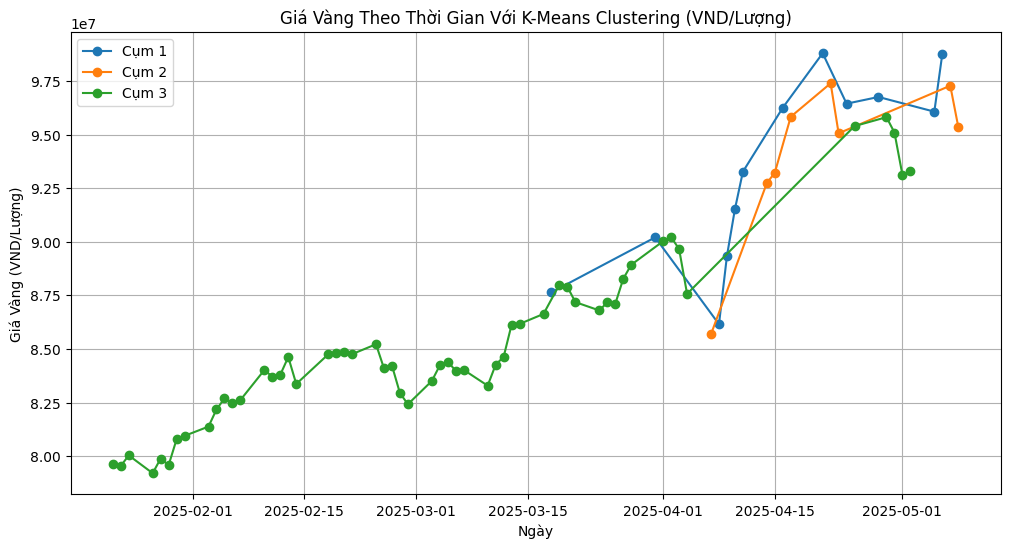

In [43]:
#Biểu đồ giá vàng theo cụm KMeans.

plt.figure(figsize=(12, 6))
for cluster in np.unique(kmeans_clusters + 1):
    cluster_data = data[data['KMeans_Cluster'] == cluster]
    plt.plot(cluster_data['Date'], cluster_data['Gold_Price_VND_per_Luong'], label=f'Cụm {cluster}', marker='o', linestyle='-')
plt.title('Giá Vàng Theo Thời Gian Với K-Means Clustering (VND/Lượng)')
plt.xlabel('Ngày')
plt.ylabel('Giá Vàng (VND/Lượng)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Vẽ scatter plot so sánh giữa Hierarchical Clustering và K-Means Clustering

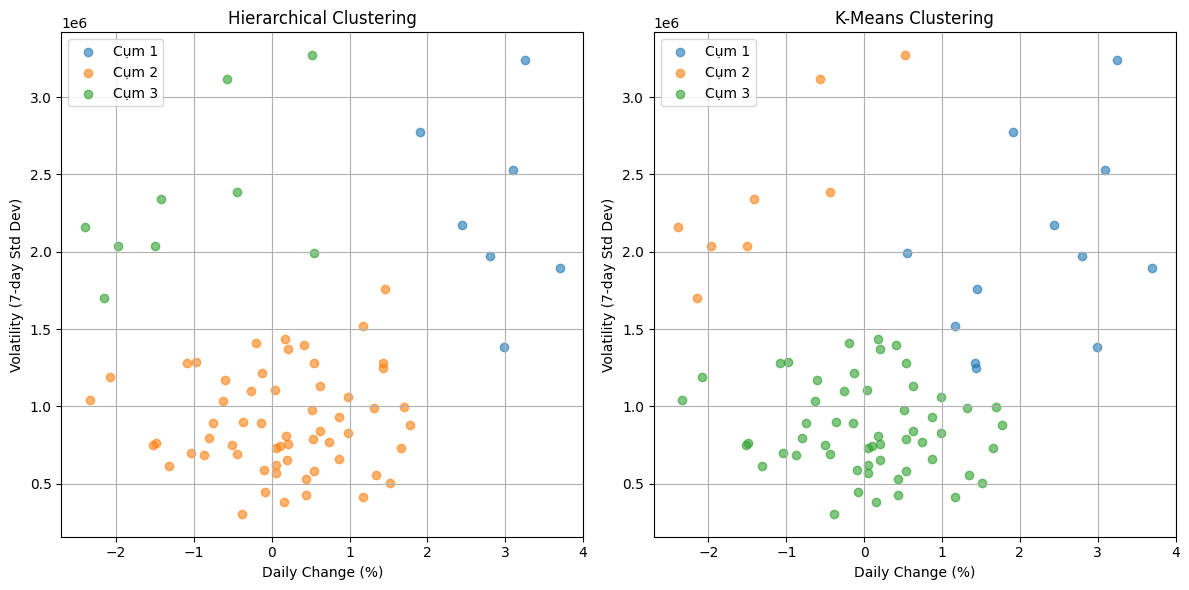

**Nếu bạn muốn thử số cụm khác, thay đổi t=3 (Hierarchical) và n_clusters=3 (K-Means). Để chọn số cụm tối ưu cho K-Means, bạn có thể thêm Elbow Method để tham khảo như bên dưới**


In [44]:
#Biểu đồ phân tán giữa Daily Change và Volatility cho cả 2 phương pháp.

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for cluster in np.unique(hierarchical_clusters):
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['Daily_Change'], cluster_data['Volatility'], label=f'Cụm {cluster}', alpha=0.6)
plt.title('Hierarchical Clustering')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for cluster in np.unique(kmeans_clusters + 1):
    cluster_data = data[data['KMeans_Cluster'] == cluster]
    plt.scatter(cluster_data['Daily_Change'], cluster_data['Volatility'], label=f'Cụm {cluster}', alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel('Daily Change (%)')
plt.ylabel('Volatility (7-day Std Dev)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("**Nếu bạn muốn thử số cụm khác, thay đổi t=3 (Hierarchical) và n_clusters=3 (K-Means). Để chọn số cụm tối ưu cho K-Means, bạn có thể thêm Elbow Method để tham khảo như bên dưới**")

***Mở rộng bài toán
Chọn số cụm tối ưu bằng Elbow Method (K-Means)

Elbow Method giúp xác định số cụm hợp lý cho K-Means bằng cách vẽ biểu đồ giữa:

Số cụm (k) và

Tổng phương sai nội cụm (Inertia)

Khi đường biểu đồ bắt đầu "gãy khúc" (giống hình khuỷu tay), đó là số cụm phù hợp nhất.

=>  Ý nghĩa thực tế:

Giúp tránh chọn số cụm quá nhiều hoặc quá ít, đảm bảo việc phân cụm là tối ưu và hợp lý

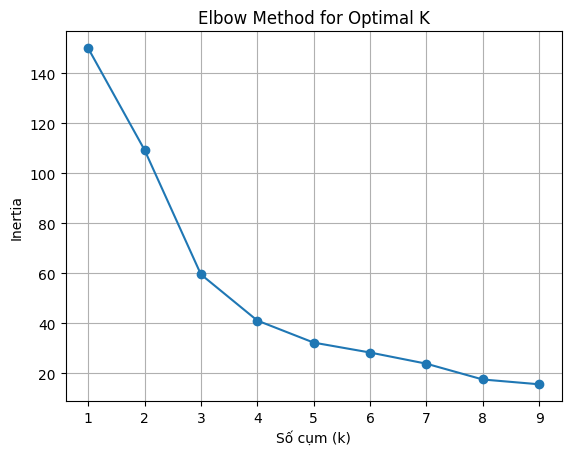

In [45]:
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


** Thêm biểu đồ phân bố dữ liệu theo thời gian
    Biểu đồ đường thời gian giúp thấy rõ:

    Chu kỳ tăng/giảm của giá vàng

    Những giai đoạn biến động bất thường hoặc ổn định

=> Biểu đồ này giúp người nghe hình dung được các giai đoạn thị trường có dấu hiệu ổn định hay khủng hoảng — từ đó giúp đưa ra chiến lược đầu tư phù hợp.

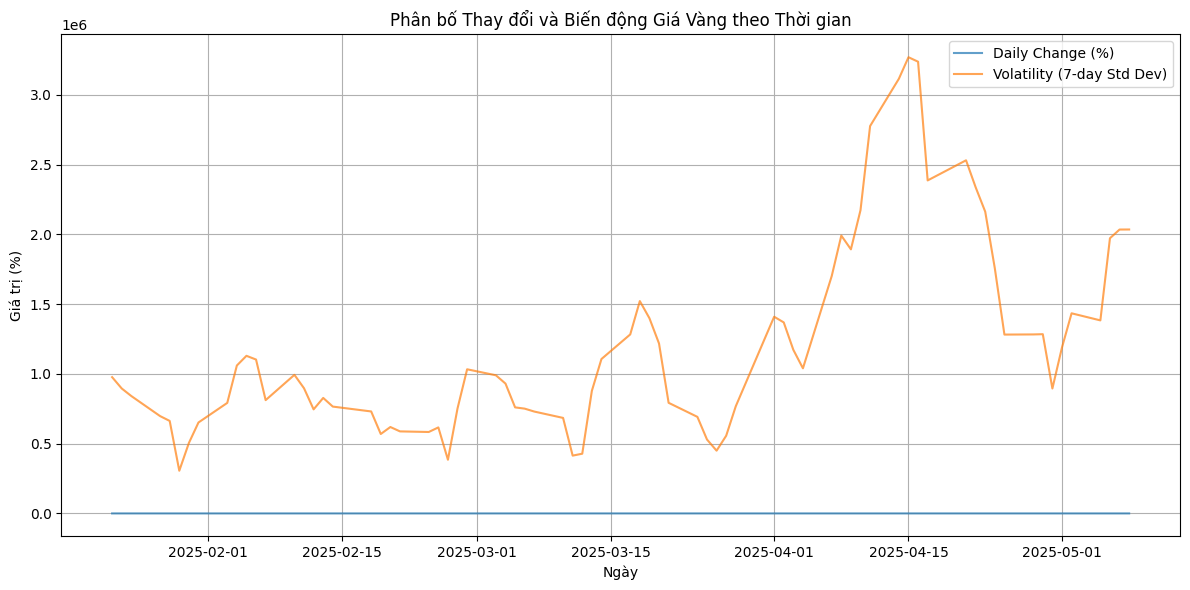

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Daily_Change'], label='Daily Change (%)', alpha=0.7)
plt.plot(data['Date'], data['Volatility'], label='Volatility (7-day Std Dev)', alpha=0.7)
plt.title('Phân bố Thay đổi và Biến động Giá Vàng theo Thời gian')
plt.xlabel('Ngày')
plt.ylabel('Giá trị (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Giải thích từng phần**
1. Chuẩn bị dữ liệu
    * Dữ liệu giá vàng được tải từ Yahoo Finance (GLD), quy đổi sang VND/lượng.
    * Tính hai đặc trưng: Daily_Change (% thay đổi giá hàng ngày) và Volatility (độ lệch chuẩn 7 ngày).
2. Áp dụng Hierarchical Clustering
    * Sử dụng linkage với phương pháp average và chia thành 3 cụm bằng fcluster
3. Áp dụng K-Means Clustering:
    * Sử dụng KMeans từ sklearn với k=3, random_state=42 để đảm bảo kết quả có thể tái lập.
4. Đánh giá hiệu suất
    * Silhouette Score: Đo lường mức độ tách biệt giữa các cụm (giá trị từ -1 đến 1, càng cao càng tốt).
    * Davies-Bouldin Index: Đo lường tỷ lệ giữa độ phân tán trong cụm và khoảng cách giữa các cụm (càng thấp càng tốt).
5. Trực quan hóa:
    * Vẽ biểu đồ giá vàng theo thời gian với các cụm từ cả hai phương pháp.
    * Vẽ scatter plot để so sánh cách các điểm dữ liệu được phân cụm.
6. So sánh hiệu suất (dự kiến)
    - Silhouette Score
    * Nếu K-Means có điểm cao hơn, điều này cho thấy các cụm được phân tách tốt hơn, vì K-Means tối ưu hóa trực tiếp khoảng cách đến tâm cụm.
    * Hierarchical Clustering có thể có điểm thấp hơn nếu dữ liệu không có cấu trúc cụm rõ ràng (do nó dựa trên khoảng cách liên kết).
    - Davies-Bouldin Index
    * K-Means thường cho chỉ số thấp hơn (tốt hơn) nếu dữ liệu có dạng hình cầu (spherical), vì K-Means giả định các cụm có hình dạng này.
    * Hierarchical Clustering có thể hoạt động tốt hơn nếu dữ liệu có cấu trúc phức tạp hơn (ví dụ: cụm không hình cầu).
7. So sánh thực tế
    - Tốc độ
    * K-Means nhanh hơn (độ phức tạp O(n*k*i) với 𝑘 k là số cụm, 𝑖 i là số lần lặp).
    * Hierarchical Clustering chậm hơn (độ phức tạp 𝑂 ( 𝑛^2 ) O(n^2 ) hoặc 𝑂 ( 𝑛^3 ) O(n^3 ) tùy phương pháp liên kết).
    - Tính linh hoạt
    * Hierarchical Clustering không cần xác định trước số cụm và cung cấp dendrogram để trực quan hóa.
    * K-Means yêu cầu chọn k trước, nhưng có thể dùng phương pháp như Elbow Method để xác định k.
8. Kết quả
    * Trong biểu đồ giá vàng, nếu các cụm từ Hierarchical Clustering và K-Means có sự khác biệt lớn, điều này cho thấy dữ liệu có thể không phù hợp với giả định của * K-Means (cụm hình cầu). Scatter plot sẽ giúp bạn thấy rõ cách hai phương pháp phân cụm khác nhau.
9 Mở rộng bài toán phân tích thêm với K-Mean (xem phần ***)